In [1]:
import sys
sys.path.append('/opt/ml/code')

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from spam.transform import get_transform
from spam.dataset import MaskDataset, EvalDataset
from spam.trainer import Trainer
from spam.loss import LabelSmoothing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , ConcatDataset
from torchvision import models

from efficientnet_pytorch import EfficientNet

In [28]:
## hyperparameters

model_name = 'efficientnet-b0'
device = 'cuda'
batch_size = 32
lr = 0.00006
num_epoch = 50
target = 'gender'
fold = 3

df_train_path = f'df/fold/df_train_fold2_{fold}.csv'
df_valid_path = f'df/fold/df_valid_fold2_{fold}.csv'

# df_train_path = f'df/fold/df_train_fold{fold}.csv'
# df_valid_path = f'df/fold/df_valid_fold{fold}.csv'
#df_test_path = '/opt/ml/input/data/eval/info.csv'

df_train = pd.read_csv(df_train_path)
df_valid = pd.read_csv(df_valid_path)
#df_train = pd.concat([df_train, pd.read_csv('df/df_gender_filtered.csv')])
#df_test = pd.read_csv(df_test_path)

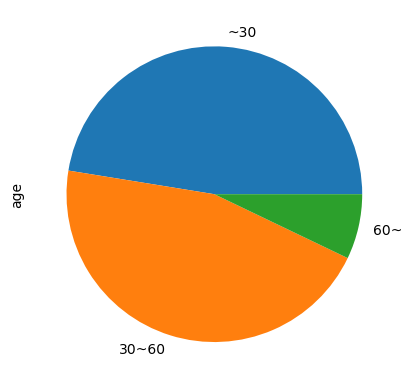

In [32]:
df = pd.concat([df_train, df_valid])
df.age.value_counts().plot(kind='pie', labels=['~30', '30~60', '60~'])
plt.show()

In [12]:
# import pickle
# df_valid = pd.read_csv('/opt/ml/input/data/eval/info.csv')
# with open('pkl/ensembled_age5.pkl', 'rb') as f:
#     df_valid['age'] = pickle.load(f)
# df_valid['path'] = '/opt/ml/input/data/eval/images/' + df_valid['ImageID']
#df_valid = pd.read_csv('df/df_pseudo.csv')

In [13]:
## seeds

random_seed = fold

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [14]:
# bins = [0, 29, 58, 100]
# labels = [0, 1, 2]
# df_train['age'] = pd.cut(df_train['age_real'], bins=bins, labels=labels)
# df_valid['age'] = pd.cut(df_valid['age_real'], bins=bins, labels=labels)

In [15]:
input_size = EfficientNet.get_image_size(model_name)
print(input_size)

224


In [16]:
## transform

transform_train = get_transform(augment=True, crop=350, resize=input_size, cutout=100)
transform_valid = get_transform(augment=False, crop=350, resize=input_size, cutout=None)

In [17]:
## prepare dataset

train_dataset = MaskDataset(df=df_train, transform=transform_train, target=target)
valid_dataset = MaskDataset(df=df_valid, transform=transform_valid, target=target)

In [18]:
# # if using external dataset

# df_ff_path = f'df/fold/df_ff{fold}.csv'
# df_ff = pd.read_csv(df_ff_path)
#transform_ff = get_transform(augment=True, crop=400, resize=input_size, cutout=100)
# ff_dataset = TrainDataset(df=df_ff, transform=transform_ff, target=target)

# df_mega_path = 'df/df_megaasian_2000.csv'
# df_mega = pd.read_csv(df_mega_path)
# transform_mega = get_transform(augment=True, crop=224, resize=224, cutout=100)
# mega_dataset = TrainDataset(df=df_mega, transform=transform_mega, target=target)

# df_train = pd.concat([df_mega, df_train])
# train_dataset = ConcatDataset([mega_dataset, train_dataset])

In [19]:
## prepare sampler

from torch.utils.data.sampler import WeightedRandomSampler

weight = df_train[target].value_counts().sort_index().to_numpy()
print('count :', weight)
weight = 1. / weight
samples_weight = np.array([weight[t] for t in df_train[target]])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight)//4)

count : [12160 12319]


In [20]:
## prepare dataloader

dataloaders = {
                'train' : DataLoader(train_dataset, batch_size=batch_size, num_workers=3, drop_last=True, sampler=sampler),
                'valid' : DataLoader(valid_dataset, batch_size=batch_size, num_workers=3, drop_last=False, shuffle=False),
              }

In [24]:
a = iter(dataloaders['train'])

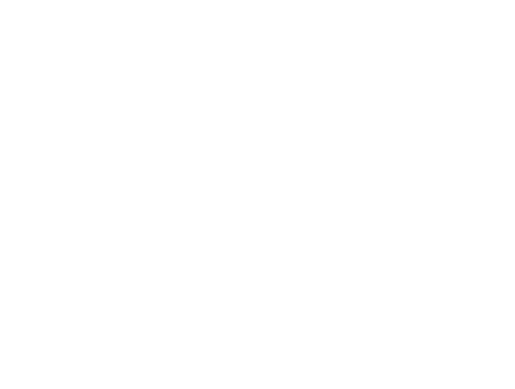

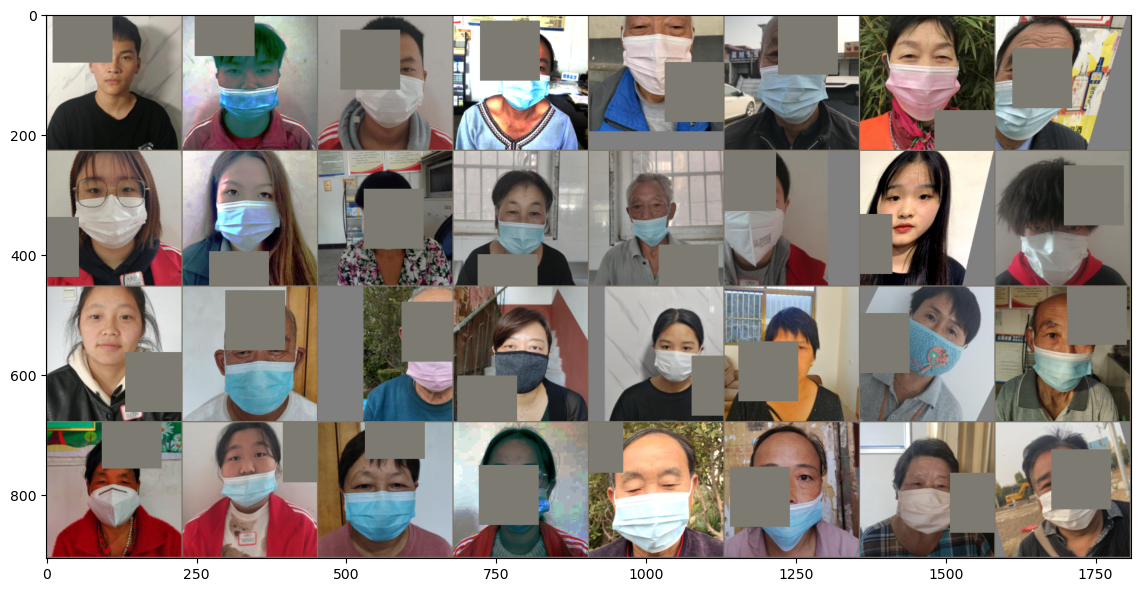

tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0])


(0.0, 1.0, 0.0, 1.0)

In [27]:
# check input train batch

from spam.utils import imshow
batch = next(a)
imshow(batch[0])
print(batch[1])
plt.axis('off')

In [ ]:
## prepare model

if model_name.startswith('efficientnet'):
    model = EfficientNet.from_pretrained(model_name, num_classes=2 if target=='gender' else 3)
elif model_name.startswith('tf'):
    import timm
    model = timm.create_model('tf_efficientnetv2_b3', pretrained=True, num_classes=2 if target=='gender' else 3)
else:
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
    
model.to(device)
print(model_name, 'ready')

In [ ]:
criterion = LabelSmoothing(0.05)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = None #optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma = 0.2)

## Train

In [ ]:
trainer = Trainer('/opt/ml/code/save')

In [ ]:
# ## resume
# # model.load_state_dict(torch.load('/opt/ml/code/save/label/effnet_test018.pt'))

# change lr manually:
for g in optimizer.param_groups:
    g['lr'] = 0.00006

In [ ]:
trainer.train(model, dataloaders, criterion, optimizer, device, num_epochs=num_epoch, scheduler=lr_scheduler,
              sub_dir='gender_pseudo', save_name='epoch_')

## Logs

In [ ]:
# gender filtered
fold1: valid Epoch: 18 Loss: 0.1294 Acc: 0.9957 F1: 0.9954831964152352
fold2: valid Epoch: 10 Loss: 0.1319 Acc: 0.9948 F1: 0.9944877469030033
fold3:

In [ ]:
# mask filtered
fold1: valid Epoch: 1 Loss: 0.1763 Acc: 0.9983 F1: 0.9971124847823342
fold2: valid Epoch: 13 Loss: 0.1766 Acc: 0.9989 F1: 0.9984395851005393
fold3: valid Epoch: 19 Loss: 0.1734 Acc: 0.9992 F1: 0.9988874048105277

기본 설정

```
model_name = 'efficientnet-b0'
batch_size = 64
lr = 0.00006
split = 20
transform_train = get_transform(augment=True, crop=350, resize=224, cutout=100)
transform_valid = get_transform(augment=False, crop=350, resize=224, cutout=None)
sampler size = 1/4
```

In [ ]:
fold1 : valid Epoch: 4 Loss: 0.3962 Acc: 0.8862 F1: 0.821721722503823
fold2 : valid Epoch: 40 Loss: 0.4248 Acc: 0.9093 F1: 0.8422249509480482
fold3 : valid Epoch: 11 Loss: 0.3709 Acc: 0.9132 F1: 0.8585660098591014
fold4 : valid Epoch: 23 Loss: 0.4540 Acc: 0.8907 F1: 0.8095942352403456
fold5 :

In [ ]:
fold1 : valid Epoch: 5 Loss: 0.4595 Acc: 0.8489 F1: 0.8031238726415671
fold2 : valid Epoch: 6 Loss: 0.4431 Acc: 0.8548 F1: 0.8012658188332825
fold3 : valid Epoch: 10 Loss: 0.4506 Acc: 0.8553 F1: 0.8058200704748169
fold4 : valid Epoch: 9 Loss: 0.4908 Acc: 0.8450 F1: 0.7906665769542832
fold5 : valid Epoch: 7 Loss: 0.4672 Acc: 0.8320 F1: 0.7799060662626397

#age

fold1: valid Epoch: 17 Loss: 0.4579 Acc: 0.8815 F1: 0.8027899336626833
fold2: 2 Loss: 0.3948 Acc: 0.8873 F1: 0.7839202809114848
fold3: valid Epoch: 15 Loss: 0.4004 Acc: 0.8926 F1: 0.8191606755937846
fold4: valid Epoch: 11 Loss: 0.5041 Acc: 0.8847 F1: 0.7889797678502543
fold5: valid Epoch: 4 Loss: 0.4097 Acc: 0.8878 F1: 0.7903932227018299

#mask

fold1 : valid Epoch: 25 Loss: 0.1786 Acc: 0.9987 F1: 0.9981495185578444
fold2 : valid Epoch: 24 Loss: 0.1767 Acc: 0.9989 F1: 0.9980246913580246
fold3 : valid Epoch: 15 Loss: 0.1744 Acc: 0.9995 F1: 0.9992581597278271
fold4 : valid Epoch: 17 Loss: 0.1720 Acc: 0.9997 F1: 0.9996299037115689
fold5: valid Epoch: 40 Loss: 0.1749 Acc: 0.9989 F1: 0.9985185185185186

## Gender folds
```python
model_name = 'efficientnet-b3'
batch_size = 64
optimizer = Adam
lr = 0.00006
transform_train = get_transform(augment=True, crop=350, resize=300, cutout=100)
transform_valid = get_transform(augment=False, crop=350, resize=300, cutout=None)
```

|Fold|Epoch|valid Loss|Acc|F1|
|----|-----|----------|---|--|
|1|23|0.1251|0.9979|0.9978|
|2|21|0.1265|0.9976|0.9975|
|3|14|0.1366|0.9934|0.9930|
|4|?|0.1392|0.9918|0.9914|
|5|?|0.1366|0.9929|0.9925|

In [ ]:
valid Epoch: 5 Loss: 0.1823 Acc: 0.9979 F1: 0.9967814699501073

## Age Log

1. tf_eff b3 + ff:  
    - epoch23)  
      - train Loss: 0.2512 Acc: 0.9638 F1: 0.963731509280305
      - valid Loss: 0.4652 Acc: 0.9042 F1: 0.7983025945957932

2. tf_eff b3 + mega:  
    - epoch14)  
      - train Loss: 0.2475 Acc: 0.9683 F1: 0.9683685312363205
      - valid Loss: 0.4115 Acc: 0.9106 F1: 0.8063435215039828

## Gender Experiment Logs

2. tf effb3 0.0003->0.00006
   epoch 17)
      - train Loss: 0.1367 Acc: 0.9912 F1: 0.9911960535284283
      - valid Loss: 0.1314 Acc: 0.9944 F1: 0.9941665702144545

2. ff, AdamW(wd=0.0001) lr 0.00006 --> 0.00001
   epoch ?)
      - train Loss: 0.1550 Acc: 0.9821 F1: 0.9821238701547585
      - valid Loss: 0.1367 Acc: 0.9913 F1: 0.9908242378118639

valid Loss: 0.1367 Acc: 0.9913 F1: 0.9908242378118639
    


## Mask Experiment Logs

---

1. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 21)
      - train Loss: 0.2192 Acc: 0.9767 F1: 0.9766713917541754
      - valid Loss: 0.1739 Acc: 0.9989 F1: 0.9985207090460696
        

## Age & Gender Experiment Logs

---

### loss function test

---

1. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=CE, WeightedSampler, split 25%, optimizer=Adam
   * epoch 18)
     - train Loss: 0.0991 Acc: 0.9655 F1: 0.9654261306812848
     - valid Loss: 0.0980 Acc: 0.9778 F1: 0.9772288369633227  
  * before first patience

---

2. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=LS(0.05), WeightedSampler, split 25%, optimizer=Adam
    * epoch 21)
     - train Loss: 0.3310 Acc: 0.9638 F1: 0.963728513759618
     - valid Loss: 0.3071 Acc: 0.9786 F1: 0.9791634664746235 

---

3. eff b0, lr=0.00006, bs=64, randaug+cutout, inputsize=224, loss_fn=F1_Loss, split 25%, optimizer=Adam
   * epoch 13)
     - train Loss: 0.0710 Acc: 0.9584 F1: 0.9476713834498373
     - valid Loss: 0.0403 Acc: 0.9765 F1: 0.9748789208889367
   * epoch 3)
     - train Loss: 0.0594 Acc: 0.9655 F1: 0.9555452013464937
     - valid Loss: 0.0369 Acc: 0.9782 F1: 0.9776768545260203

---

### split ratio test

---

4. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 15%
    * epoch 21)
      - train Loss: 0.3381 Acc: 0.9597 F1: 0.9597144587078792
      - valid Loss: 0.2948 Acc: 0.9852 F1: 0.982564296238198
      
---

5. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 20%
    * epoch 27)
      - train Loss: 0.3211 Acc: 0.9668 F1: 0.9668728849468181
      - valid Loss: 0.2878 Acc: 0.9854 F1: 0.9842203787970396
      
---

6. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 25%
    * epoch 22)
      - train Loss: 0.3321 Acc: 0.9639 F1: 0.9638739223128628
      - valid Loss: 0.2910 Acc: 0.9829 F1: 0.9792575649184908
      
---

7. model=eff b0, optimizer=Adam, lr=0.00006, bs=64, augment=randaug+cutout, inputsize=224, loss_fn=LS(0.05), split 30%
    * epoch 29)
      - train Loss: 0.3171 Acc: 0.9686 F1: 0.9685813478405522
      - valid Loss: 0.3047 Acc: 0.9772 F1: 0.9764751322879572

## Debug

In [ ]:
model.load_state_dict(torch.load('/opt/ml/code/save/gender/best_20_log2.pt'))
model.eval()
print('ready')

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

model.eval()
y_true = []
y_pred = []
wrong = []
for inputs, labels in dataloaders['valid']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        
        for p, t, inp in zip(preds, labels, inputs):
            if p.item() != t.item():
                wrong.append((inp.cpu().numpy(), p.item(), t.item()))

mtx = confusion_matrix(y_true, y_pred)
print(mtx)


In [ ]:
d = {y_true:y_true, 'y_pred'

with open('pred.pkl', 'wb') as f:
    pickle.dump(list, f)

In [ ]:
label_ = list(range(6))

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(mtx, cmap='Blues', vmax=100, vmin=-20)

ax.set_xticks(np.arange(len(label_)))
ax.set_yticks(np.arange(len(label_)))
# ... and label them with the respective list entries
ax.set_xticklabels(label_)
ax.set_yticklabels(label_)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(label_)):
    for j in range(len(label_)):
        if mtx[i, j]:
            text = ax.text(j, i, mtx[i, j],
                           ha="center", va="center", color="w", size=10)
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')
ax.set_title("Confusion mtx")
fig.tight_layout()
plt.show()

In [ ]:
iterator = iter(wrong)

label = ["Male with mask", "Female with Mask", "Male incorrect mask", "Female no mask", "Male incorrect mask", "Female no mask"]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ax in axes.flatten():
    img, p, t = next(iterator)
    img = img.transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f't : {label[t]}\np : {label[p]}')
plt.show()